<a href="https://colab.research.google.com/github/Elikul/analys-information/blob/main/classification7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.utils import to_categorical
from keras.layers import Dense
from keras.models import Model
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

In [15]:
# отключает жаждующие исполнение, нужно для языковой модели elmo, которую здесь использую, чтобы работала с tensorflow 2
tf.compat.v1.disable_eager_execution()

Загружаем датасет

In [16]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

url = 'https://www.kaggle.com/datasets/terrychanorg/pred-spam-text-message-classification'

od.download(url)

Skipping, found downloaded files in "./pred-spam-text-message-classification" (use force=True to force download)


In [17]:
data_path = './pred-spam-text-message-classification/spam-text.csv'

Предобработка данных датасета

In [18]:
text_spam_df = pd.read_csv(data_path, encoding='latin-1')

In [19]:
le = LabelEncoder()

In [20]:
x = text_spam_df['text'].to_numpy()
y = le.fit_transform(list(text_spam_df['label']))

Выделяем выборки для обучения, валидации и теста

In [21]:
def get_index(percent):
  dataset_size = text_spam_df.shape[0]
  return int(dataset_size * percent)

In [22]:
train_index = get_index(0.4)
x_train = np.asarray(x[:train_index])
y_train = np.asarray(y[:train_index])

In [23]:
val_index = get_index(0.3) +  train_index
x_val = np.asarray(x[train_index:val_index])
y_val = np.asarray(y[train_index:val_index])

In [24]:
x_test = np.asarray(x[val_index:])
y_test = np.asarray(y[val_index:])

Языковая модель ELMO от tensorflow_hub

In [25]:
elmo = "https://tfhub.dev/google/elmo/3"
# берём слой языковой модели на архитектуре ELMO
hub_layer = hub.KerasLayer(elmo, input_shape=[], dtype=tf.string, trainable=False)
hub_layer(x_train)

<tf.Tensor 'keras_layer_1/StatefulPartitionedCall:0' shape=(2228, 1024) dtype=float32>

Модель

In [26]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1024)              93600852  
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 93,863,509
Trainable params: 262,657
Non-trainable params: 93,600,852
_________________________________________________________________


Функция потерь и оптимизатор

In [27]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Обучаем модель

In [28]:
history = model.fit(x_train,
                    y_train,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    epochs=2,
                    verbose=1)

Train on 2228 samples, validate on 1671 samples
Epoch 1/2
2228/2228 [==============================] - ETA: 0s - loss: 0.1639 - accuracy: 0.9183 

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


2228/2228 [==============================] - 1099s 493ms/sample - loss: 0.1639 - accuracy: 0.9183 - val_loss: 0.0836 - val_accuracy: 0.9791
Epoch 2/2
2228/2228 [==============================] - 1131s 508ms/sample - loss: 0.0560 - accuracy: 0.9807 - val_loss: 0.0631 - val_accuracy: 0.9808


In [29]:
model.save('ELMoModel.h5')

Оценить модель

In [30]:
results = model.evaluate(x_test, y_test, batch_size=64, verbose=2)

In [31]:
for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

loss: 0.055
accuracy: 0.983


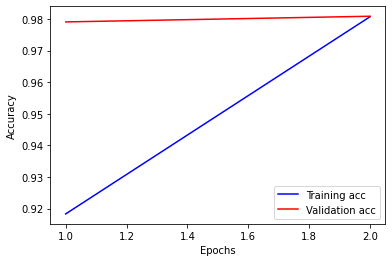

In [32]:
history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'b', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

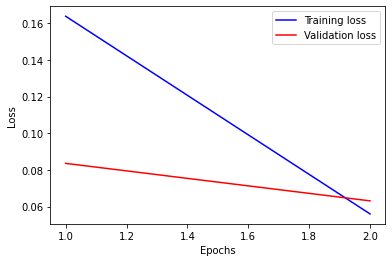

In [33]:
loss_values = history_dict['loss']
val_los_values = history_dict['val_loss']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, loss_values, 'b', label='Training loss')
plt.plot(epochs, val_los_values, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Пробуем распознование

In [34]:
predicts = model.predict(x_test)

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [35]:
y_pred = np.concatenate(np.around(predicts), axis=0)

Оценка результата классификации с помощью метрик

In [36]:
print(metrics.classification_report(y_test, y_pred, target_names=["ham","spam"]))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1445
        spam       0.98      0.89      0.93       228

    accuracy                           0.98      1673
   macro avg       0.98      0.95      0.96      1673
weighted avg       0.98      0.98      0.98      1673

